In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import geopy.distance
from geopy.distance import distance as geopy_distance

path = r'E:\Summers\release\taxi_log_2008_by_id'

txt_files = [f for f in os.listdir(path) if f.endswith('.txt')]

txt_files.sort()

txt_files = txt_files[:40]
data = []

#Reading every txt file
for file in txt_files:
    file_path = os.path.join(path, file)
    with open(file_path, 'r') as f:
        for line in f:
            data.append(line.strip().split(','))

df = pd.DataFrame(data, columns=['ID', 'Timestamp', 'Longitude', 'Latitude'])

df['ID'] = df['ID'].astype(int)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Longitude'] = df['Longitude'].astype(float)
df['Latitude'] = df['Latitude'].astype(float)

print(df)


          ID           Timestamp  Longitude  Latitude
0          1 2008-02-02 15:36:08  116.51172  39.92123
1          1 2008-02-02 15:46:08  116.51135  39.93883
2          1 2008-02-02 15:46:08  116.51135  39.93883
3          1 2008-02-02 15:56:08  116.51627  39.91034
4          1 2008-02-02 16:06:08  116.47186  39.91248
...      ...                 ...        ...       ...
63588  10032 2008-02-08 17:28:04  116.28844  39.77719
63589  10032 2008-02-08 17:30:32  116.28414  39.78335
63590  10032 2008-02-08 17:33:06  116.28433  39.79427
63591  10032 2008-02-08 17:35:46  116.28646  39.80653
63592  10032 2008-02-08 17:38:08  116.29586  39.81120

[63593 rows x 4 columns]


In [ ]:
print(df.head(15000))

          ID           Timestamp  Longitude  Latitude
0          1 2008-02-02 15:36:08  116.51172  39.92123
1          1 2008-02-02 15:46:08  116.51135  39.93883
2          1 2008-02-02 15:46:08  116.51135  39.93883
3          1 2008-02-02 15:56:08  116.51627  39.91034
4          1 2008-02-02 16:06:08  116.47186  39.91248
...      ...                 ...        ...       ...
14995  10003 2008-02-08 07:09:45  117.00042  40.55755
14996  10003 2008-02-08 07:14:47  117.00042  40.55754
14997  10003 2008-02-08 07:19:49  117.00041  40.55756
14998  10003 2008-02-08 07:24:51  117.00040  40.55755
14999  10003 2008-02-08 07:29:53  117.00041  40.55754

[15000 rows x 4 columns]


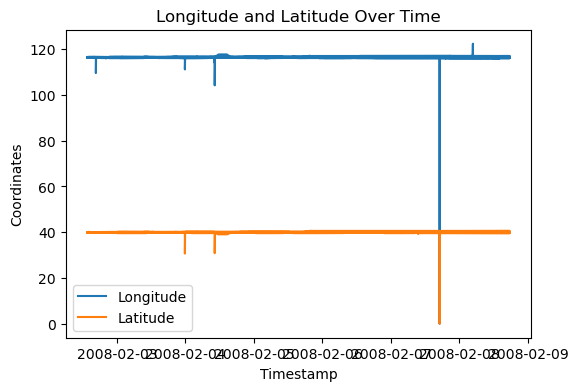

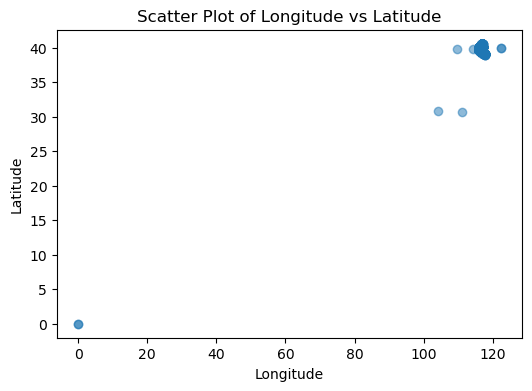

C:\Users\dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


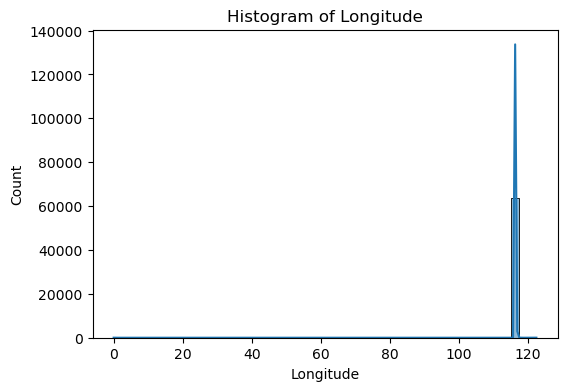

C:\Users\dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


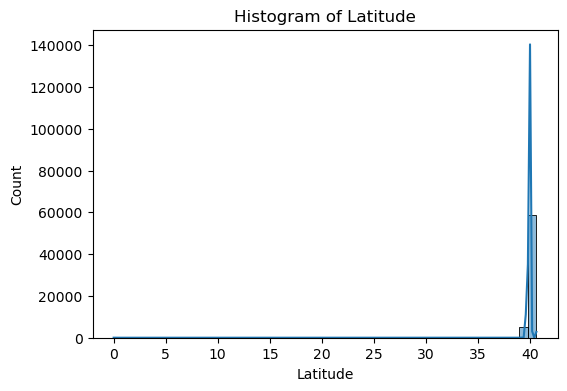

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df['Timestamp'], df['Longitude'], label='Longitude')
plt.plot(df['Timestamp'], df['Latitude'], label='Latitude')
plt.xlabel('Timestamp')
plt.ylabel('Coordinates')
plt.title('Longitude and Latitude Over Time')
plt.legend()
plt.show()

#Scatter plot of Longitude vs Latitude
plt.figure(figsize=(6, 4))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude vs Latitude')
plt.show()

# Histogram of Longitude
plt.figure(figsize=(6, 4))
sns.histplot(df['Longitude'], bins=50, kde=True)
plt.xlabel('Longitude')
plt.title('Histogram of Longitude')
plt.show()

# Histogram of Latitude
plt.figure(figsize=(6, 4))
sns.histplot(df['Latitude'], bins=50, kde=True)
plt.xlabel('Latitude')
plt.title('Histogram of Latitude')
plt.show()


In [ ]:
subset_df = df.head(15000)

#Initialize an empty list to store distances
distances = []

#Calculate Euclidean distances between consecutive points
for i in range(len(subset_df) - 1):
    lat1, lon1 = subset_df.iloc[i]['Latitude'], subset_df.iloc[i]['Longitude']
    lat2, lon2 = subset_df.iloc[i+1]['Latitude'], subset_df.iloc[i+1]['Longitude']
    distance = np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)
    distances.append(distance)

distances_df = pd.DataFrame(distances, columns=['Euclidean Distance'])

print(distances_df.head(1000))

     Euclidean Distance
0              0.017604
1              0.000000
2              0.028912
3              0.044462
4              0.012504
..                  ...
995            0.002684
996            0.000076
997            0.001060
998            0.000370
999            0.002628

[1000 rows x 1 columns]


In [ ]:
!pip install geopy


In [ ]:
#hash functions
grid_sizes = [0.01, 0.02, 0.05]

def hash_to_grid(lat, lon, grid_size):
    lat_hash = int(lat // grid_size)
    lon_hash = int(lon // grid_size)
    return (lat_hash, lon_hash)

#Apply multiple hash functions to the dataset
for grid_size in grid_sizes:
    column_name = f'Grid_{grid_size}'
    df[column_name] = df.apply(lambda row: hash_to_grid(row['Latitude'], row['Longitude'], grid_size), axis=1)

print(df.head())
print(df[['ID', 'Timestamp', 'Latitude', 'Longitude'] + [f'Grid_{grid_size}' for grid_size in grid_sizes]].head())


   ID           Timestamp  Longitude  Latitude      Grid_0.01     Grid_0.02  \
0   1 2008-02-02 15:36:08  116.51172  39.92123  (3992, 11651)  (1996, 5825)   
1   1 2008-02-02 15:46:08  116.51135  39.93883  (3993, 11651)  (1996, 5825)   
2   1 2008-02-02 15:46:08  116.51135  39.93883  (3993, 11651)  (1996, 5825)   
3   1 2008-02-02 15:56:08  116.51627  39.91034  (3991, 11651)  (1995, 5825)   
4   1 2008-02-02 16:06:08  116.47186  39.91248  (3991, 11647)  (1995, 5823)   

     Grid_0.05  
0  (798, 2330)  
1  (798, 2330)  
2  (798, 2330)  
3  (798, 2330)  
4  (798, 2329)  
   ID           Timestamp  Latitude  Longitude      Grid_0.01     Grid_0.02  \
0   1 2008-02-02 15:36:08  39.92123  116.51172  (3992, 11651)  (1996, 5825)   
1   1 2008-02-02 15:46:08  39.93883  116.51135  (3993, 11651)  (1996, 5825)   
2   1 2008-02-02 15:46:08  39.93883  116.51135  (3993, 11651)  (1996, 5825)   
3   1 2008-02-02 15:56:08  39.91034  116.51627  (3991, 11651)  (1995, 5825)   
4   1 2008-02-02 16:06:08  3

In [ ]:
# grid size
grid_size = 0.01

#Function to hash the coordinates into grid cells
def hash_to_grid(lat, lon, grid_size):
    lat_hash = int(lat // grid_size)
    lon_hash = int(lon // grid_size)
    return (lat_hash, lon_hash)

df['Grid'] = df.apply(lambda row: hash_to_grid(row['Latitude'], row['Longitude'], grid_size), axis=1)

num_bands = 4
rows_per_band = 2

#Dict for band buckets
band_buckets = defaultdict(lambda: defaultdict(list))

#hash values into bands and rows
def divide_into_bands(hash_value, num_bands, rows_per_band):
    bands = []
    for i in range(num_bands):
        band = hash_value[i * rows_per_band:(i + 1) * rows_per_band]
        bands.append(band)
    return bands

#Iterate through the dataset and group points into band buckets
for index, row in df.iterrows():
    hash_value = row['Grid']
    bands = divide_into_bands(hash_value, num_bands, rows_per_band)
    for band_index, band in enumerate(bands):
        band_buckets[band_index][band].append((row['ID'], row['Timestamp'], row['Longitude'], row['Latitude']))

for band_index, bands in band_buckets.items():
    print(f"Band {band_index}:")
    for band_code, points in bands.items():
        print(f"  Band Code: {band_code}, Points: {points[:5]}")


Band 0:
  Band Code: (3992, 11651), Points: [(1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-06 19:21:22'), 116.51167, 39.92152), (100, Timestamp('2008-02-06 01:54:53'), 116.51262, 39.92204), (1000, Timestamp('2008-02-02 21:14:56'), 116.51891, 39.92262), (1000, Timestamp('2008-02-06 11:25:26'), 116.51135, 39.92198)]
  Band Code: (3993, 11651), Points: [(1, Timestamp('2008-02-02 15:46:08'), 116.51135, 39.93883), (1, Timestamp('2008-02-02 15:46:08'), 116.51135, 39.93883), (1, Timestamp('2008-02-06 19:31:21'), 116.51127, 39.93078), (1000, Timestamp('2008-02-07 11:00:26'), 116.51135, 39.93159), (10013, Timestamp('2008-02-07 15:17:23'), 116.5106, 39.93361)]
  Band Code: (3991, 11651), Points: [(1, Timestamp('2008-02-02 15:56:08'), 116.51627, 39.91034), (1, Timestamp('2008-02-04 17:38:21'), 116.51175, 39.9155), (1, Timestamp('2008-02-05 11:38:33'), 116.51525, 39.9159), (1, Timestamp('2008-02-06 10:35:37'), 116.51523, 39.91522), (1, Timestamp('2008-02-06 15:

In [ ]:
df = df.head(200)
grid_size = 0.01

#Func to hash the coordinates into grid
def hash_to_grid(lat, lon, grid_size):
    lat_hash = int(lat // grid_size)
    lon_hash = int(lon // grid_size)
    return (lat_hash, lon_hash)

df['Grid'] = df.apply(lambda row: hash_to_grid(row['Latitude'], row['Longitude'], grid_size), axis=1)

num_bands = 4
rows_per_band = 1

#Dict to store band buckets
band_buckets = defaultdict(lambda: defaultdict(list))

#hash values into bands and rows
def divide_into_bands(hash_value, num_bands, rows_per_band):
    hash_str = ''.join(map(str, hash_value))
    band_size = len(hash_str) // num_bands
    bands = [hash_str[i * band_size:(i + 1) * band_size] for i in range(num_bands)]
    return bands

#Iterating through the dataset and group points into bands
for index, row in df.iterrows():
    hash_value = row['Grid']
    bands = divide_into_bands(hash_value, num_bands, rows_per_band)
    for band_index, band in enumerate(bands):
        band_buckets[band_index][band].append((row['ID'], row['Timestamp'], row['Longitude'], row['Latitude']))


candidate_pairs = defaultdict(list)
# Generating candidate pairs
for band_index, bands in band_buckets.items():
    for band_code, points in bands.items():
        num_points = len(points)
        if num_points > 1:
            for i in range(num_points):
                for j in range(i + 1, num_points):
                    pair = (points[i], points[j])
                    candidate_pairs[band_index].append(pair)


for band_index, pairs in candidate_pairs.items():
    print(f"Candidate Pairs from Band {band_index}:")
    for pair in pairs[:10]:
        print(pair)


Candidate Pairs from Band 0:
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 15:46:08'), 116.51135, 39.93883))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 15:46:08'), 116.51135, 39.93883))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 15:56:08'), 116.51627, 39.91034))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 16:06:08'), 116.47186, 39.91248))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 16:16:08'), 116.47217, 39.92498))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 16:26:08'), 116.47179, 39.90718))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 16:36:08'), 116.45617, 39.90531))
((1, Timestamp('2008-02-02 15:36:08'), 116.51172, 39.92123), (1, Timestamp('2008-02-02 17:00:24'), 116.47191, 39.90577))
((1

In [ ]:
def haversine(lat1, lon1, lat2, lon2):

    """Calculating the great-circle distance between two points on the Earth specified in decimal degrees"""

    # Decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
# Radius of Earth in kilometers. Use 3956 for miles. In this case, we use 6371 km.
    km = 6371 * c
    return km

small_df = df.head(1000)

# Initialize an empty distance matrix
distance_matrix = np.zeros((len(small_df), len(small_df)))

# Fill the distance matrix
for i in range(len(small_df)):
    for j in range(len(small_df)):
        distance_matrix[i, j] = haversine(
            small_df.iloc[i]['Latitude'], small_df.iloc[i]['Longitude'],
            small_df.iloc[j]['Latitude'], small_df.iloc[j]['Longitude']
        )

distance_matrix_df = pd.DataFrame(distance_matrix)
print(distance_matrix_df.head())


        0         1         2         3         4         5         6    \
0  0.000000  1.957285  1.957285  1.271570  3.535911  3.398349  3.746771   
1  1.957285  0.000000  0.000000  3.195604  4.463674  3.678580  4.875069   
2  1.957285  0.000000  0.000000  3.195604  4.463674  3.678580  4.875069   
3  1.271570  3.195604  3.195604  0.000000  3.795226  4.098167  3.810112   
4  3.535911  4.463674  4.463674  3.795226  0.000000  1.390188  0.589363   

        7         8         9    ...        190        191        192  \
0  5.057681  3.805706  0.865986  ...  17.188555  17.179300  17.179038   
1  6.002929  4.982542  2.735399  ...  18.178676  18.167531  18.167402   
2  6.002929  4.982542  2.735399  ...  18.178676  18.167531  18.167402   
3  5.156659  3.817651  0.944868  ...  16.323190  16.315075  16.314737   
4  1.557747  0.746130  2.972260  ...  19.933767  19.927010  19.926585   

         193        194        195       196       197       198       199  
0  17.186049  14.369025  10.33221

In [ ]:
#Extracting Coordinates from Candidate Pairs
candidate_coords = []
for band_index, pairs in candidate_pairs.items():
    for pair in pairs:
        point1, point2 = pair
#Appending the coordinates of the first point
        candidate_coords.append(point1[2:])
        candidate_coords.append(point2[2:])
#Removing duplicates
candidate_coords = list(set(candidate_coords))

candidate_df = pd.DataFrame(candidate_coords, columns=['Longitude', 'Latitude'])

#DBSCAN
def haversine_distance(coords1, coords2):
    lat1, lon1 = np.radians(coords1)
    lat2, lon2 = np.radians(coords2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    #Radius of Earth in kilometers
    return 6371 * c



#Extracting coordinates
coords = candidate_df[['Latitude', 'Longitude']].values

#DBSCAN parameters
# Maximum distance between two, for them to be considered as in the same neighborhood (in km)
eps = 0.5
# The number of samples in a neighborhood for a point to be considered as a core point
min_samples = 5

#DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=haversine_distance).fit(coords)

candidate_df['Cluster'] = db.labels_

#Results
if len(set(db.labels_)) > 1:
    silhouette_avg = silhouette_score(coords, db.labels_)
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print('Silhouette Score cannot be calculated with only one cluster or no clusters.')

print(candidate_df.head(100))
print(candidate_df['Cluster'].value_counts())


Silhouette Score: 0.8779930667953694
    Longitude  Latitude  Cluster
0   116.69166  39.85159        0
1   116.69163  39.85156        0
2   116.67003  39.87709       -1
3   116.51135  39.93883       -1
4   116.69159  39.85128        0
..        ...       ...      ...
95  116.69176  39.85165        0
96  116.69151  39.85193        0
97  116.69165  39.85179        0
98  116.69155  39.85181        0
99  116.69155  39.85166        0

[100 rows x 3 columns]
Cluster
 0    145
-1     34
Name: count, dtype: int64


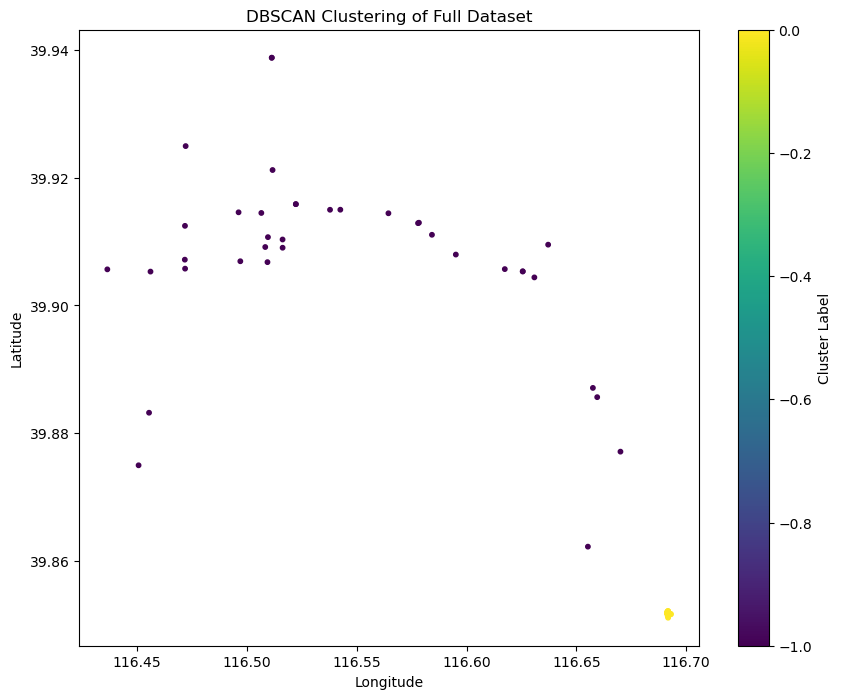

Execution Time for Full Dataset DBSCAN: 0.3300325870513916 seconds
Silhouette Score: 0.8826526087348683


In [ ]:
#execution time
start_time = time.time()

#Apply DBSCAN to the full dataset
db = DBSCAN(eps=0.5, min_samples=5, metric=haversine_distance).fit(df[['Latitude', 'Longitude']])
#silhouette score
silhouette_avg = silhouette_score(df[['Latitude', 'Longitude']], db.labels_)

#plotting clusters
plt.figure(figsize=(10, 8))
plt.scatter(df['Longitude'], df['Latitude'], c=db.labels_, cmap='viridis', s=10)
plt.title('DBSCAN Clustering of Full Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

print(f"Execution Time for Full Dataset DBSCAN: {time.time() - start_time} seconds")
print(f"Silhouette Score: {silhouette_avg}")
